In [115]:
import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
import pandas as pd

In [116]:
df = pd.read_csv('./train.csv')

In [117]:
# Load data

data = df.values.astype(np.float32)
np.random.shuffle(data)
X = data[:, 1:]
Y = data[:, 0]

Xtrain = X[:-1000]
Ytrain = Y[:-1000]
Xtest  = X[-1000:]
Ytest  = Y[-1000:]

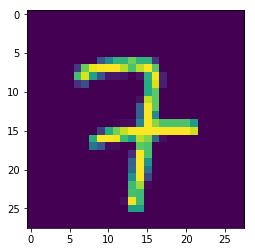

In [118]:
s = np.reshape(Xtrain[0], (28, 28))
plt.imshow(s)
plt.show()

In [119]:
# normalizie the data

mu = Xtrain.mean(axis=0)
std = Xtrain.std(axis=0)

np.place(std, std == 0, 1)

Xtrain = (Xtrain - mu) / std
Xtest = (Xtest - mu) / std

In [120]:
# change y to hot encoder

def y2indicator(y):

    y = y.astype(np.int32)
    ind = np.zeros((len(y), 10))

    for i in range(len(y)):
        ind[i, y[i]] = 1
        
    return ind 

In [121]:
def error_rate(p, t):
    return np.mean(p != t)

In [122]:
def relu(a):
    return a * (a > 0)

In [123]:
Ytrain_ind = y2indicator(Ytrain)
Ytest_ind = y2indicator(Ytest)

In [124]:
# data is ready

Xtrain = Xtrain.astype(np.float32)
Xtest = Xtest.astype(np.float32)
Ytrain = Ytrain.astype(np.float32)
Ytest = Ytest.astype(np.float32)
Ytrain_ind = Ytrain_ind.astype(np.float32)
Ytest_ind = Ytest_ind.astype(np.float32)

In [125]:
# initial values

max_iter = 15
print_period = 100

lr = 0.0004
reg = 0.01 #smooth parameter

N, D = Xtrain.shape
batch_sz = 500
n_batches = N // batch_sz

M = 300
K = 10

In [126]:
W1_init = np.random.randn(D, M) / 28
b1_init = np.zeros(M)
W2_init = np.random.randn(M, K) / np.sqrt(M)
b2_init = np.zeros(K)

Neural Network with batch

In [141]:
# step 2: define theano variables and expressions
thX = T.matrix('X')
thT = T.matrix('T')
W1 = theano.shared(W1_init, 'W1')
b1 = theano.shared(b1_init, 'b1')
W2 = theano.shared(W2_init, 'W2')
b2 = theano.shared(b2_init, 'b2')

In [142]:
# we can use the built-in theano functions to do relu and softmax
thZ = relu( thX.dot(W1) + b1 )  
thY = T.nnet.softmax( thZ.dot(W2) + b2 )

In [143]:
# define the cost function and prediction
#cost = -(thT * T.log(thY)).sum()

#L1 regularization
#cost = -(thT * T.log(thY)).sum() + reg*((W1*W1).sum() + (b1*b1).sum() + (W2*W2).sum() + (b2*b2).sum())

#L2 regularization
cost = -(thT * T.log(thY)).sum() + reg*(np.abs(W1).sum() + np.abs(b1).sum() + np.abs(W2).sum() + np.abs(b2).sum())

prediction = T.argmax(thY, axis=1)

In [144]:
# step 3: training expressions and functions
# we can just include regularization as part of the cost because it is also automatically differentiated!
update_W1 = W1 - lr*T.grad(cost, W1)
update_b1 = b1 - lr*T.grad(cost, b1)
update_W2 = W2 - lr*T.grad(cost, W2)
update_b2 = b2 - lr*T.grad(cost, b2)

In [145]:
train = theano.function(
    inputs=[thX, thT],
    updates=[(W1, update_W1), (b1, update_b1), (W2, update_W2), (b2, update_b2)],
)

In [146]:
# create another function for this because we want it over the whole dataset
get_prediction = theano.function(
    inputs=[thX, thT],
    outputs=[cost, prediction],
)

Cost / err at iteration i=0, j=0, cost_value: 1869.423, error: 0.526
Cost / err at iteration i=1, j=0, cost_value: 313.373, error: 0.063
Cost / err at iteration i=2, j=0, cost_value: 259.364, error: 0.054
Cost / err at iteration i=3, j=0, cost_value: 233.642, error: 0.046
Cost / err at iteration i=4, j=0, cost_value: 218.045, error: 0.041
Cost / err at iteration i=5, j=0, cost_value: 205.972, error: 0.041
Cost / err at iteration i=6, j=0, cost_value: 197.714, error: 0.039
Cost / err at iteration i=7, j=0, cost_value: 192.273, error: 0.038
Cost / err at iteration i=8, j=0, cost_value: 185.907, error: 0.039
Cost / err at iteration i=9, j=0, cost_value: 181.532, error: 0.037
Cost / err at iteration i=10, j=0, cost_value: 177.897, error: 0.033
Cost / err at iteration i=11, j=0, cost_value: 174.903, error: 0.031
Cost / err at iteration i=12, j=0, cost_value: 172.091, error: 0.032
Cost / err at iteration i=13, j=0, cost_value: 169.871, error: 0.032
Cost / err at iteration i=14, j=0, cost_val

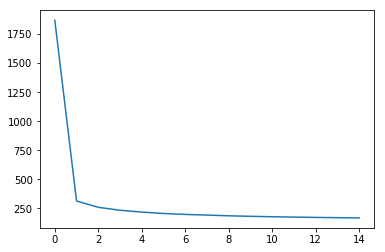

In [147]:
costs = []
for i in range(max_iter):
    for j in range(n_batches):
        Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz),]
        Ybatch = Ytrain_ind[j*batch_sz:(j*batch_sz + batch_sz),]

        train(Xbatch, Ybatch)
        if j % print_period == 0:
            cost_val, prediction_val = get_prediction(Xtest, Ytest_ind)
            err = error_rate(prediction_val, Ytest)
            print("Cost / err at iteration i=%d, j=%d, cost_value: %.3f, error: %.3f" % (i, j, cost_val, err))
            costs.append(cost_val)

plt.plot(costs)
plt.show()